In [1]:
from datetime import datetime
from time import time
from contextlib import contextmanager
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr,kruskal
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from tsai.all import *
import os
import torch
torch.manual_seed(0)

def modis_date(data_str):
    ano = int(data_str[1:5])
    dia_ano = int(data_str[5:])
    data = datetime.strptime('{}-{}'.format(ano, dia_ano), '%Y-%j')
    return data

nee = pd.read_csv('./Dados_Utilizados/nee_mean.csv', header=None)
nee.index = nee[2].apply(modis_date)  # Convertendo a data no formato MODIS

# Arrumando o dataframe
nee = nee.drop([0,1,2,3,4], axis=1)
nee.columns = range(len(nee.columns))
nee = nee[4]
nee_ate_2023 = nee.loc[:'2023-12-31']



#nee_ate_2023.rename('NEE', inplace=True)
#nee_ate_2023.to_csv("NEE_Santarem.csv", index=False) # Salvando o arquivo


# Nesta etapa, o arquivo NEE_Santarem.csv foi aberto no main.r para utilização do pacote "forecast" do R para remoção de possíveis outliers


# Leia o arquivo NEE_Santarem.csv após a remoção dos outliers
nee_ate_2023 = pd.read_csv("Dados_Utilizados/cleaned_NEE_Santarem.csv")
nee_ate_2023.index = nee.loc[:'2023-12-31'].index

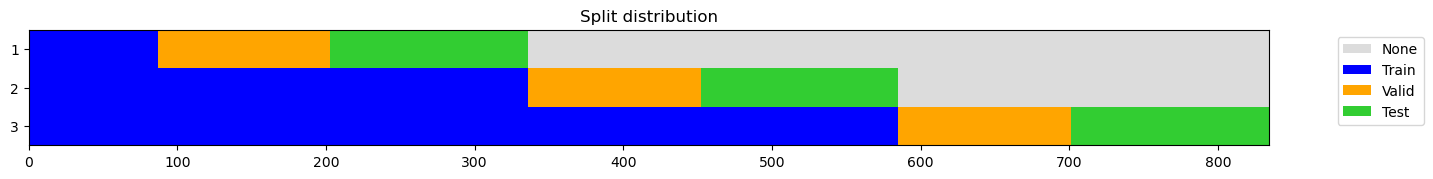

In [2]:
X, y = SlidingWindow(7,horizon=7,stride=4)(nee.values)
splits = get_walk_forward_splits(X,valid_size=0.14,test_size=0.16,n_splits=3,anchored=True)

### Reconstrução do dataset de teste 

In [ ]:
"""O conjunto de dados original foi dividido conjuntos de treino, validação e teste com sobreposição.
 No entanto, a avaliação do desempenho dos modelos no conjunto de teste depende das datas originais do período de teste, que são perdidas com a sobreposição.
 Dessa forma, o conjunto de teste foi redefinido sem sobreposição para restabelecer o período original, replicando um cenário real de teste dos modelos."""

In [3]:
def recontruct(target):
    reconstructed_array = []
    for i in range(len(target)):
        if i == 0:
            # Adiciona o primeiro conjunto de 'y'
            reconstructed_array.extend(target[i])
        else:
            # Adiciona apenas os novos valores que não foram incluídos na janela anterior
            reconstructed_array.extend(target[i][-3:])

    # Convertendo de volta para numpy array
    reconstructed_array = np.array(reconstructed_array)
    return reconstructed_array

reconstructed_y = recontruct(y[splits[2][2]])
reconstructed_x = recontruct(X[splits[2][2]].reshape(-1,7))

In [4]:
# Verificar o tamanho dos arrays
print("Tamanho de reconstructed_y:", reconstructed_y.size)
print("Tamanho de reconstructed_x:", reconstructed_x.size)

# Ajustar reconstructed_y para múltiplos de 7, se necessário
if reconstructed_y.size % 7 != 0:
    print("O tamanho de reconstructed_y não é múltiplo de 7, removendo elementos extras...")
    excess_y = reconstructed_y.size % 7
    reconstructed_y = reconstructed_y[:-excess_y]

# Ajustar reconstructed_x para múltiplos de 7, se necessário
if reconstructed_x.size % 7 != 0:
    print("O tamanho de reconstructed_x não é múltiplo de 7, removendo elementos extras...")
    excess_x = reconstructed_x.size % 7
    reconstructed_x = reconstructed_x[:-excess_x]

# Remodelar os arrays
reconstructed_y = reconstructed_y.reshape(-1, 7)
reconstructed_x = reconstructed_x.reshape(-1, 7)

# Imprimir as formas após remodelagem
print("Shape de reconstructed_y após remodelagem:", reconstructed_y.shape)
print("Shape de reconstructed_x após remodelagem:", reconstructed_x.shape)

np.save('reajuste_do_tamanho_dos_dados/reconstructed_y.npy',reconstructed_y,allow_pickle=True)
np.save('reajuste_do_tamanho_dos_dados/reconstructed_x.npy',reconstructed_x,allow_pickle=True)

Tamanho de reconstructed_y: 403
Tamanho de reconstructed_x: 403
O tamanho de reconstructed_y não é múltiplo de 7, removendo elementos extras...
O tamanho de reconstructed_x não é múltiplo de 7, removendo elementos extras...
Shape de reconstructed_y após remodelagem: (57, 7)
Shape de reconstructed_x após remodelagem: (57, 7)


In [5]:
filtered_dates = nee[nee.isin(reconstructed_y.flatten())].index

## Treinamento das arquiteturas

Resultados médios para GRUPlus:
      arch  train loss  valid loss       MAE      RMSE
0  GRUPlus    0.338216    0.398915  0.757144  0.979169


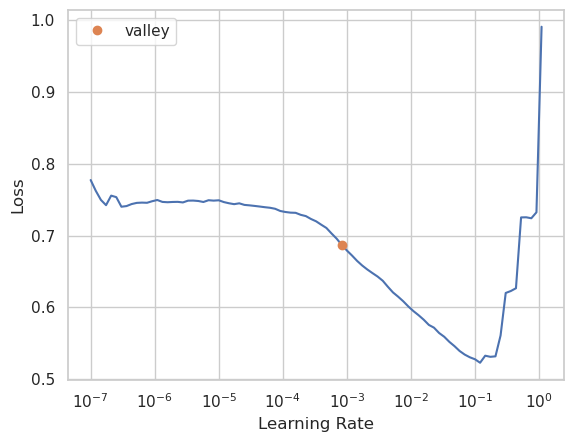

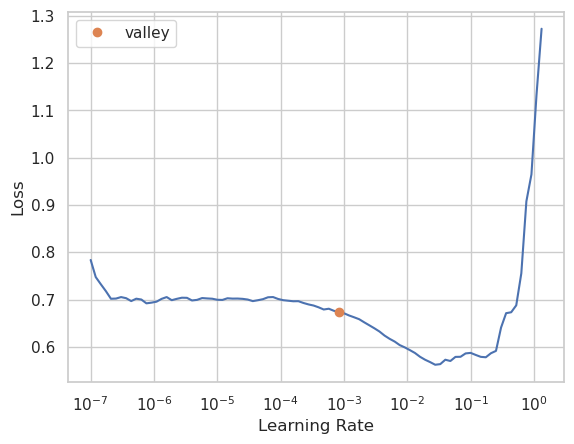

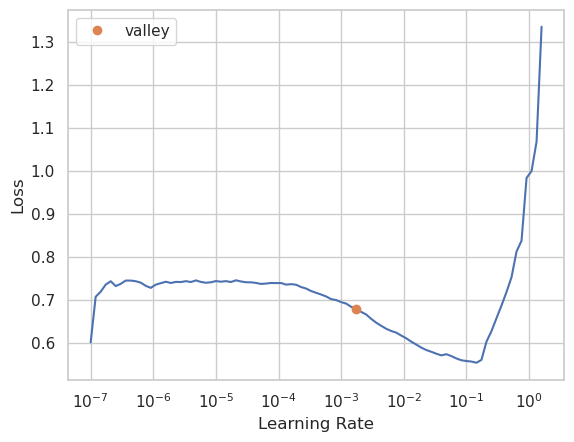

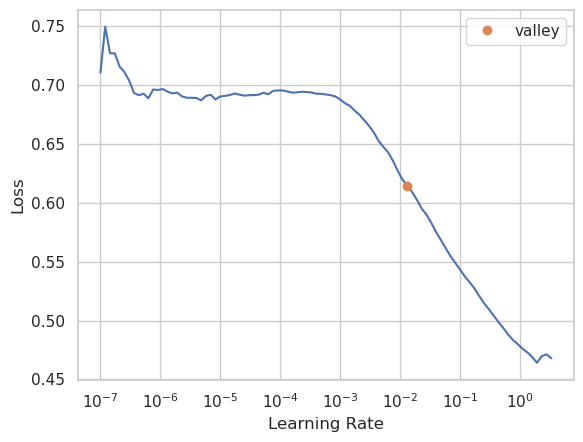

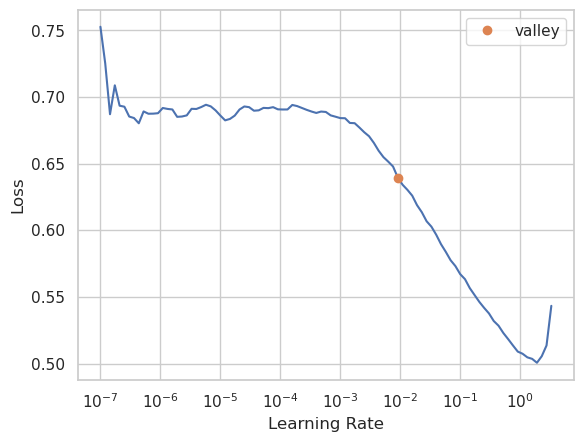

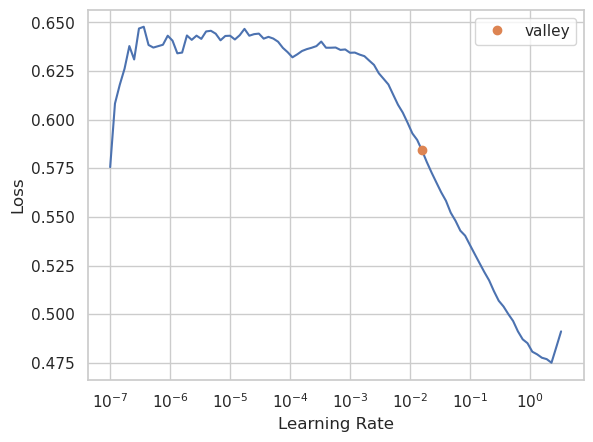

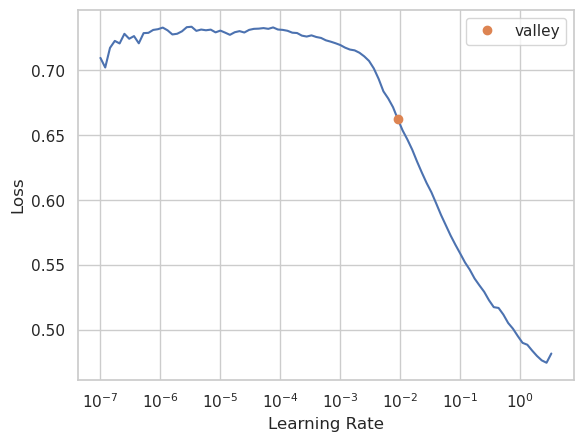

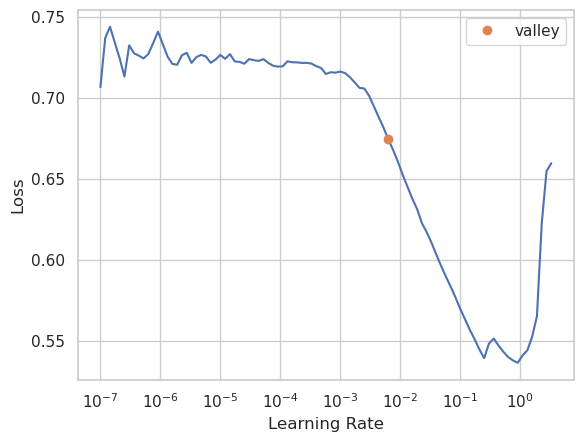

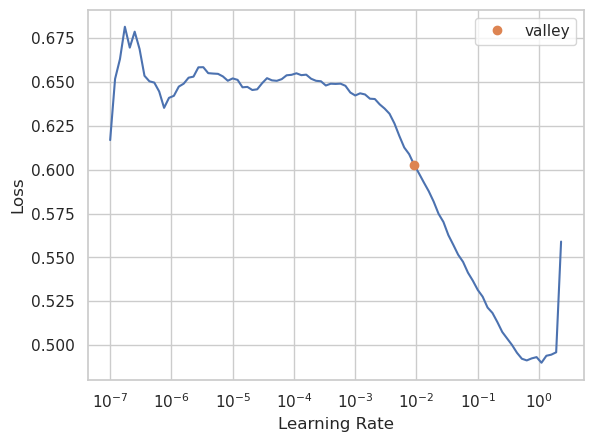

In [42]:
archs = [
         RNNPlus,
         LSTMPlus,
         GRUPlus,              
        ]

modelos = {}

resultados = {}


def test_archs(epochs):
    tfms = [None, TSForecasting()]
    for arch in archs:
        print(arch.__name__)
        
        results = pd.DataFrame(columns=['arch', 'total params', 'train loss', 'valid loss', 'mae_valid', 'rmse_valid', 'time', 'epochs'])
        i = 0
        split_numero = 1
        for split in splits:
            resultados[f'{arch.__name__}_Split_{split_numero}'] = {'train loss': [], 'valid loss': [], 'MAE': [], 'RMSE': []}
            learn = TSForecaster(X, y, splits=split, tfms=tfms, batch_tfms=TSLog(), arch=arch, metrics=[tsai.metrics.mae, tsai.metrics.rmse], device=default_device(),loss_func=HuberLoss())
            with ContextManagers([learn.no_bar(), learn.no_logging()]):
                start = time.time()
                lr = learn.lr_find()
                
                for epoch in range(1, epochs + 1):
                    learn.fit_one_cycle(1, lr_max=lr)
                    train_loss = learn.recorder.values[-1][0]
                    valid_loss = learn.recorder.values[-1][1]
                    mae = learn.recorder.values[-1][2]
                    rmse = learn.recorder.values[-1][3]
                    
                    # Armazenar os resultados por arquitetura
                    resultados[f'{arch.__name__}_Split_{split_numero}']['train loss'].append(train_loss)
                    resultados[f'{arch.__name__}_Split_{split_numero}']['valid loss'].append(valid_loss)
                    resultados[f'{arch.__name__}_Split_{split_numero}']['MAE'].append(mae)
                    resultados[f'{arch.__name__}_Split_{split_numero}']['RMSE'].append(rmse)
                    
                    # Salvar o modelo após cada 50 épocas
                    pasta = f"modelos/{arch.__name__}"
                    if not os.path.exists(os.path.join("models",pasta)):
                        os.makedirs(os.path.join("models",pasta))
                    print(os.path.join("models",pasta))
                    model_save_path = os.path.join(pasta,f"{arch.__name__}_epoch_{epoch}_split_{split_numero}.pth")
                    learn.save(model_save_path)  # Método para salvar o modelo
                    print(f"Modelo salvo em: {model_save_path}")
                    if (epoch % 50) == 0:
                        folder_path = f"./modelos/"
                        if not os.path.exists(folder_path):
                            os.makedirs(folder_path)
                            
                        elapsed = time.time() - start
                        vals = learn.recorder.values[-1]
                        results.loc[i] = [arch.__name__, count_parameters(learn.model), vals[0], vals[1], vals[2], vals[3], int(elapsed), epoch]
                        results.sort_values(by=['valid loss'], ascending=False, kind='stable', ignore_index=True, inplace=True)
                        clear_output()
                        i += 1
                
                # Armazene o modelo treinado
                modelos[f'{arch.__name__}'] = learn
                
                # Salve os resultados após cada split
                results.to_csv(f'resultados_treinamento/Split_{split_numero}_{arch.__name__}_resultados_{epochs}_epocas.csv')
                split_numero += 1
        
        # Calcular e exibir as métricas médias para cada arquitetura
        split_count = ['Split_1', 'Split_2', 'Split_3']

        avg_metrics = {
            'arch': arch.__name__,
            'train loss': np.mean([resultados[f'{arch.__name__}_{num_split}']['train loss'] for num_split in split_count]),
            'valid loss': np.mean([resultados[f'{arch.__name__}_{num_split}']['valid loss'] for num_split in split_count]),
            'MAE': np.mean([resultados[f'{arch.__name__}_{num_split}']['MAE'] for num_split in split_count]),
            'RMSE': np.mean([resultados[f'{arch.__name__}_{num_split}']['RMSE'] for num_split in split_count]),
        }
        
        avg_results = pd.DataFrame([avg_metrics])
        avg_results.to_csv(f'resultados_treinamento/{arch.__name__}_avg_resultados_{epochs}_epocas.csv')
        print(f"Resultados médios para {arch.__name__}:")
        print(avg_results)

test_archs(200) # Treinamento de 200 épocas

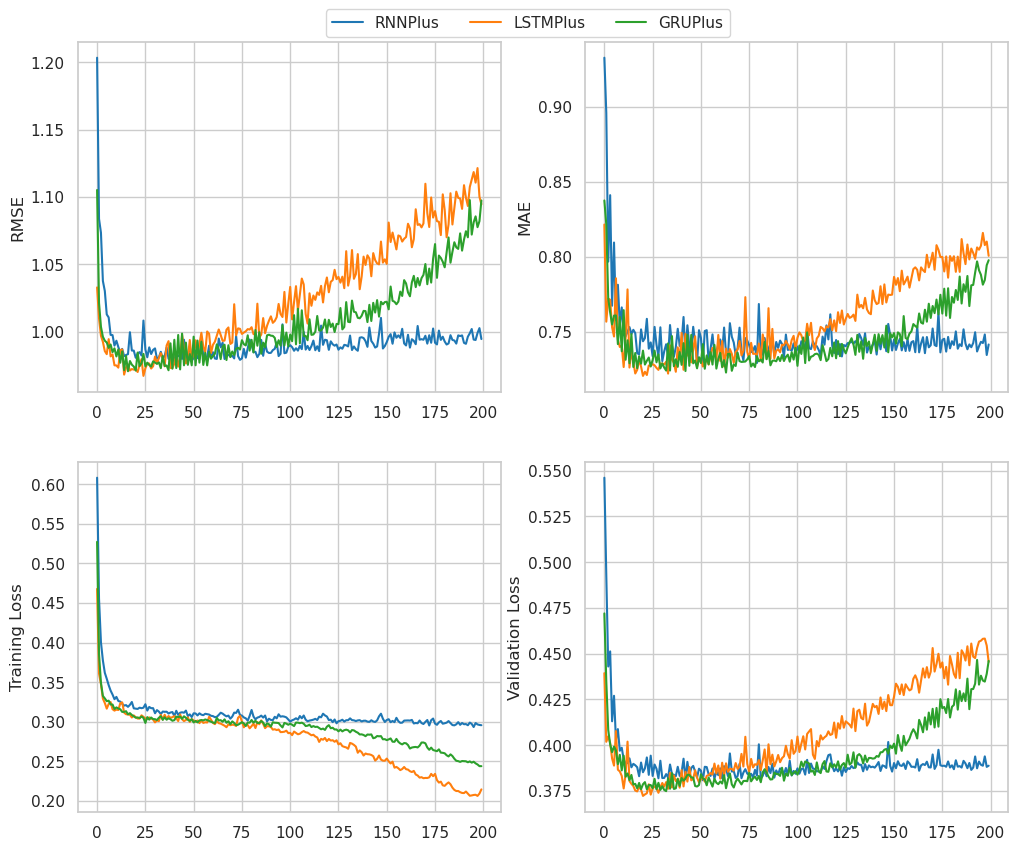

Época com menor média: 88, Arquitetura com menor média: RNNPlus_Split_3


In [134]:
# Defina as cores da linha do gráfico
colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    '#ffff14',  # yellow
    '#17becf',  # cyan
    '#aaff32'   # lime
]


fig, axs = plt.subplots(2, 2, figsize=(12, 10))

splits_completos = [arquitetura for arquitetura in list(resultados.keys()) if arquitetura.endswith("_3")]


mean_metrics = {}
best_arch = None

# Plot RMSE no dataset de validação
for idx, archs in enumerate(splits_completos):
    axs[0, 0].plot(range(len(resultados[archs]['RMSE'])), resultados[archs]['RMSE'], label=archs, color=colors[idx])
    axs[0, 0].set_ylabel('RMSE')

# Plot MAE no dataset de validação
for idx, archs in enumerate(splits_completos):
    axs[0, 1].plot(range(len(resultados[archs]['MAE'])), resultados[archs]['MAE'], label=archs, color=colors[idx])
    axs[0, 1].set_ylabel('MAE')

# Plot training loss
for idx, archs in enumerate(splits_completos):
    axs[1, 0].plot(range(len(resultados[archs]['train loss'])), resultados[archs]['train loss'], label=archs, color=colors[idx])
    axs[1, 0].set_ylabel('Training Loss')

# Plot validation loss
for idx, archs in enumerate(splits_completos):
    axs[1, 1].plot(range(len(resultados[archs]['valid loss'])), resultados[archs]['valid loss'], label=archs, color=colors[idx])
    axs[1, 1].set_ylabel('Validation Loss')

medias = []
for archs in splits_completos:
    rmse_arch = resultados[archs]['RMSE']
    mae_arch = resultados[archs]['MAE']
    train_loss_arch = resultados[archs]['train loss']
    valid_loss_arch = resultados[archs]['valid loss']
    
    # Calcule a média das métricas para cada época
    media = np.mean([rmse_arch, mae_arch, train_loss_arch, valid_loss_arch], axis=0)
    medias.append(media)

medias_array = np.array(medias)
media_total_por_epoca = np.mean(medias_array, axis=0)
media_total_por_arch = np.mean(medias_array, axis=1)

# Encontre os índices das 3 melhores arquiteturas
top_3_indices = np.argsort(media_total_por_arch)[:3]  # Obtem os indices das 3 menores médias
top_3_archs = [splits_completos[idx] for idx in top_3_indices]  # Obtem os nomes das arquiteturas

# Determinar a melhor arquitetura
best_arch = top_3_archs[0]

epocas_melhores = []

# Armazenando as épocas com menor média
for i, arch in enumerate(top_3_archs):
    # Encontre a época com menor média para a arquitetura atual
    epoca_menor_media = np.argmin(medias_array[top_3_indices[i], :])
    epocas_melhores.append(epoca_menor_media)  # Armazena a época como 1-indexed

# Acessando métricas para a melhor arquitetura
metricas_arch_menor_media = {
    'RMSE': resultados[best_arch]['RMSE'][epocas_melhores[0]],
    'MAE': resultados[best_arch]['MAE'][epocas_melhores[0]],
    'Training Loss': resultados[best_arch]['train loss'][epocas_melhores[0]],
    'Validation Loss': resultados[best_arch]['valid loss'][epocas_melhores[0]]
}

# Estilo seaborn
sns.set_style("whitegrid")
fig.legend(labels=["RNNPlus", "LSTMPlus", "GRUPlus"],
           loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=4)

# Salve a imagem e exiba o gráfico
plt.savefig('Imagens/archs_result_plot.jpeg', bbox_inches='tight', format='jpeg', dpi=300)
plt.show()

# Exibe a melhor época e arquitetura
print(f'Época com menor média: {epocas_melhores[0]}, Arquitetura com menor média: {best_arch}')

### Carregando o melhor modelo baseado na época com menor média de RMSE, MAE, Perda de treinamento e validação

In [44]:
def load_best_model(arch_name, epoch, split_num):
    arch_name = arch_name.split('_')[0]
    model_path = f"modelos/{arch_name}/{arch_name}_epoch_{epoch}_split_{split_num}.pth"
    if os.path.exists(os.path.join("models",f"{model_path}.pth")):
        learn = TSForecaster(X, y, splits=splits[split_num-1], tfms=[None, TSForecasting()], 
                             batch_tfms=TSStandardize(), arch=eval(arch_name), 
                             metrics=[tsai.metrics.mae, tsai.metrics.rmse], 
                             device=default_device(), loss_func=HuberLoss())
        learn.load(model_path)  # Método para carregar o modelo
        print(f"Modelo carregado: {model_path}")
        return learn
    else:
        print(f"Modelo não encontrado: {model_path}")
        return None


melhor_modelo = load_best_model(best_arch, epocas_melhores[0], 3)

segundo_melhor_modelo = load_best_model(top_3_archs[1], epocas_melhores[1], 3)

pior_modelo = load_best_model(top_3_archs[2], epocas_melhores[2], 3)



Modelo carregado: modelos/RNNPlus/RNNPlus_epoch_88_split_3.pth
Modelo carregado: modelos/GRUPlus/GRUPlus_epoch_31_split_3.pth
Modelo carregado: modelos/LSTMPlus/LSTMPlus_epoch_21_split_3.pth


## Análise gráfica dos erros de previsão

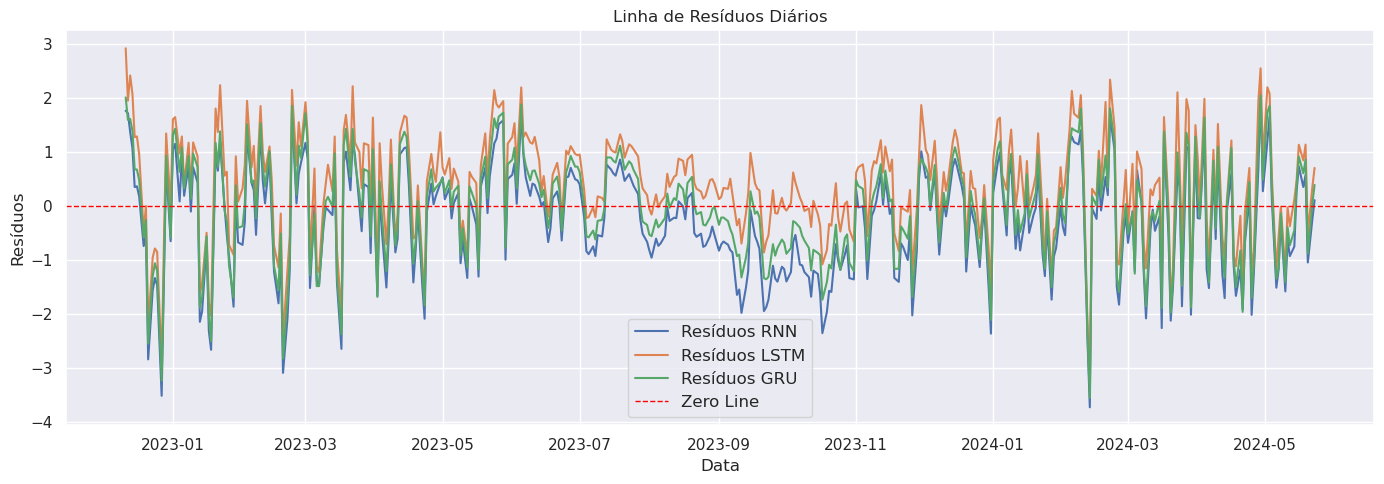

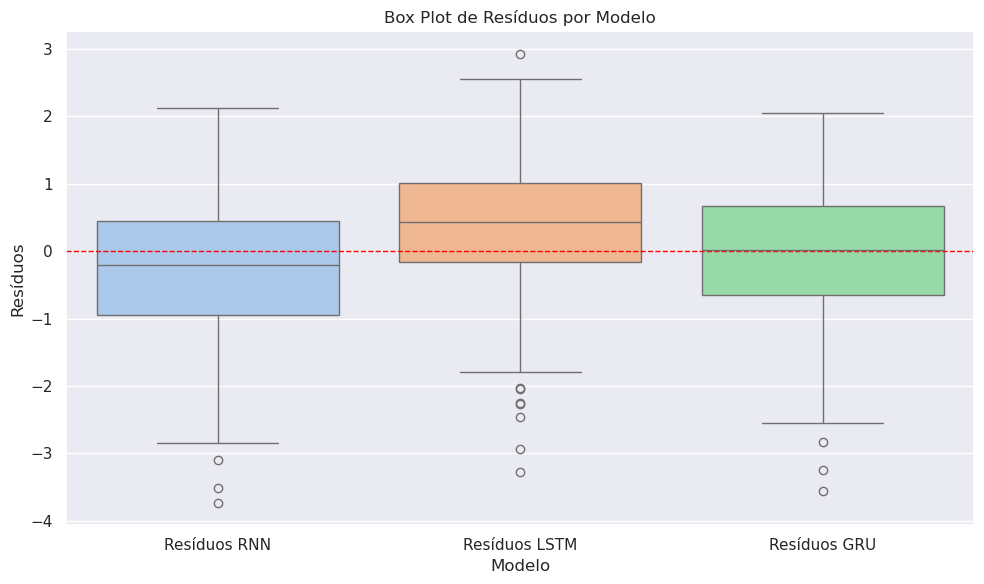

In [45]:
sns.set_style("darkgrid")
def plot_lineplot_daily(forecast1, forecast2, forecast3, target1, target2, target3, dt_index):
    # Calcula os resíduos
    preds_residuals1 = forecast1 - target1
    preds_residuals2 = forecast2 - target2
    preds_residuals3 = forecast3 - target3

    # Cria o DataFrame com os resíduos
    df_residuos = pd.DataFrame({
        'Resíduos RNN': preds_residuals1,
        'Resíduos LSTM': preds_residuals2,
        'Resíduos GRU': preds_residuals3
    }, index=dt_index)
    
    # Salva o DataFrame de resíduos em CSV
    df_residuos.to_csv('./Residuos_Dos_Modelos_Pre_Otimizacao/residuos.csv')

    # Resample para calcular a média diária dos resíduos
    df_residuos_daily = df_residuos.resample('D').mean()

    # Cria um DataFrame no formato longo para o Seaborn
    df_residuos_daily.reset_index(inplace=True)
    df_residuos_daily.rename(columns={2: 'Data'}, inplace=True)
    df_residuos_melted = df_residuos_daily.melt(id_vars='Data', var_name='Modelo', value_name='Resíduos')

    # Plota o lineplot
    fig, ax = plt.subplots(figsize=(14, 5))
    sns.lineplot(data=df_residuos_melted, x='Data', y='Resíduos', hue='Modelo', ax=ax)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Zero Line')
    ax.set_title('Linha de Resíduos Diários')
    ax.set_ylabel('Resíduos')
    ax.set_xlabel('Data')
    ax.legend(loc='lower center', fontsize=12)

    plt.tight_layout()
    plt.savefig('lineplot_daily.png')
    plt.show()


def plot_combined_boxplot(forecast1, forecast2, forecast3, target1, target2, target3):
    # Calculando os resíduos para cada modelo
    preds_residuals1 = forecast1 - target1
    preds_residuals2 = forecast2 - target2
    preds_residuals3 = forecast3 - target3

    # Criando DataFrame com os resíduos
    df_residuos = pd.DataFrame({
        'Resíduos RNN': preds_residuals1,
        'Resíduos LSTM': preds_residuals2,
        'Resíduos GRU': preds_residuals3
    })

    # Convertendo o DataFrame para o formato "longo" necessário para o Seaborn
    df_residuos_melted = df_residuos.melt(var_name='Modelo', value_name='Resíduos')

    # Criando o boxplot combinado
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_residuos_melted, x='Modelo', y='Resíduos', palette='pastel')

    # Adicionando linha horizontal para zero
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

    # Configurações do gráfico
    plt.title('Box Plot de Resíduos por Modelo')
    plt.ylabel('Resíduos')
    plt.xlabel('Modelo')

    # Ajustando o layout e salvando a figura
    plt.tight_layout()
    plt.savefig('combined_boxplot.png')
    plt.show()


datas = filtered_dates

preds_rnn, target_rnn, _ = pior_modelo.get_X_preds(reconstructed_x.reshape(57,1,7),reconstructed_y.reshape(57,7))

preds_lstm, target_lstm, _ = melhor_modelo.get_X_preds(reconstructed_x.reshape(57,1,7),reconstructed_y.reshape(57,7))

preds_gru, target_gru, _ = segundo_melhor_modelo.get_X_preds(reconstructed_x.reshape(57,1,7),reconstructed_y.reshape(57,7))


preds_rnn = preds_rnn.flatten()
preds_lstm = preds_lstm.flatten()
preds_gru = preds_gru.flatten()

target_rnn = target_rnn.flatten()
target_lstm = target_lstm.flatten()
target_gru = target_gru.flatten()

plot_lineplot_daily(preds_rnn, preds_lstm, preds_gru, target_rnn, target_lstm, target_gru,datas)
plot_combined_boxplot(preds_rnn, preds_lstm, preds_gru, target_rnn, target_lstm, target_gru)

In [46]:
np.save('predictions_targets_arrays/rnn_preds.npy', preds_rnn)
np.save('predictions_targets_arrays/lstm_preds.npy', preds_lstm)
np.save('predictions_targets_arrays/gru_preds.npy', preds_gru)
np.save('predictions_targets_arrays/target_rnn.npy', target_rnn)
np.save('predictions_targets_arrays/target_lstm.npy', target_lstm)
np.save('predictions_targets_arrays/target_gru.npy', target_gru)
np.save('predictions_targets_arrays/X.npy', X)
np.save('predictions_targets_arrays/y.npy', y)

## Análise Comparativa das predições dos modelos

In [130]:
target_rnn = np.load('predictions_targets_arrays/target_rnn.npy')
target_lstm = np.load('predictions_targets_arrays/target_lstm.npy')
target_gru = np.load('predictions_targets_arrays/target_gru.npy')
preds_rnn = np.load('predictions_targets_arrays/rnn_preds.npy')
preds_lstm = np.load('predictions_targets_arrays/lstm_preds.npy')
preds_gru = np.load('predictions_targets_arrays/gru_preds.npy')
X = np.load('predictions_targets_arrays/X.npy')
y = np.load('predictions_targets_arrays/y.npy')
reconstructed_y = np.load('reajuste_do_tamanho_dos_dados/reconstructed_y.npy',allow_pickle=True)
reconstructed_x = np.load('reajuste_do_tamanho_dos_dados/reconstructed_x.npy',allow_pickle=True)

In [131]:
rmse_rnn = np.sqrt(mean_squared_error(target_rnn, preds_rnn))
mae_rnn = mean_absolute_error(target_rnn, preds_rnn)
corr_rnn = np.corrcoef(target_rnn, preds_rnn)[0, 1]
r2_rnn = r2_score(target_rnn, preds_rnn)

# Calculate RMSE and MAE for LSTM
rmse_lstm = np.sqrt(mean_squared_error(target_lstm, preds_lstm))
mae_lstm = mean_absolute_error(target_lstm, preds_lstm)
corr_lstm = np.corrcoef(target_lstm, preds_lstm)[0, 1]
r2_lstm = r2_score(target_lstm, preds_lstm)


# Calculate RMSE and MAE for GRU
rmse_gru = np.sqrt(mean_squared_error(target_gru, preds_gru))
mae_gru = mean_absolute_error(target_gru, preds_gru)
corr_gru =  np.corrcoef(target_gru, preds_gru)[0, 1]
r2_gru = r2_score(target_gru, preds_gru)


# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Model': ['RNN', 'LSTM', 'GRU'],
    'RMSE': [rmse_rnn, rmse_lstm, rmse_gru],
    'MAE': [mae_rnn, mae_lstm, mae_gru],
    'Correlation': [corr_rnn, corr_lstm, corr_gru],
    'R2': [r2_rnn, r2_lstm, r2_gru]
})

results_df

,Model,RMSE,MAE,Correlation,R2
0,RNN,1.034238,0.821878,0.715352,0.372466
1,LSTM,1.035686,0.836669,0.704452,0.370707
2,GRU,0.963979,0.771836,0.715302,0.454830


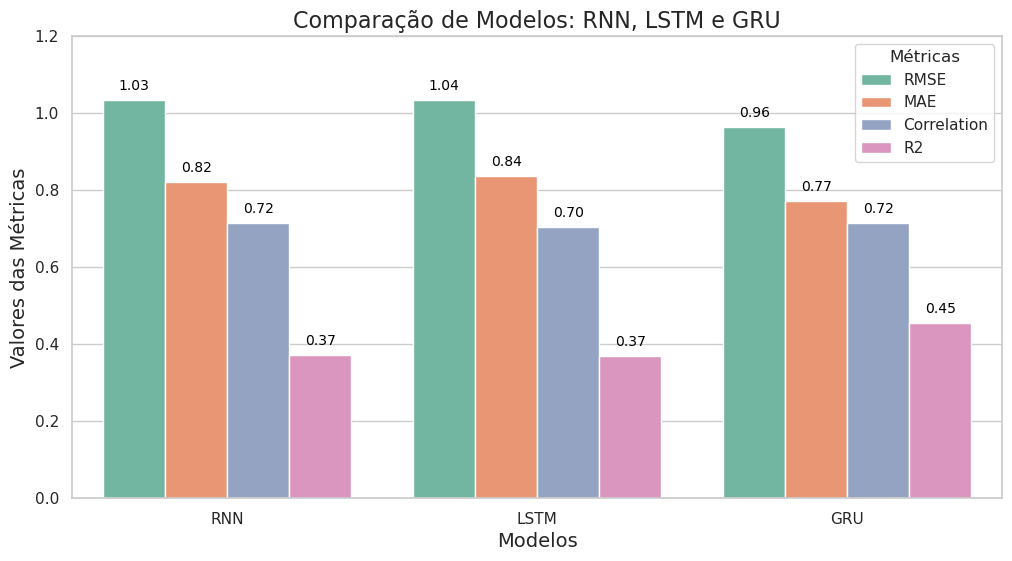

In [133]:
# Derretendo o DataFrame para um formato longo
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Configurando o estilo do gráfico
sns.set(style='whitegrid')

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=results_melted, x='Model', y='Value', hue='Metric', palette='Set2')

for p in bar_plot.patches:
    if not (p.get_height() == 0):
        bar_plot.annotate(f'{p.get_height():.2f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10, color='black', 
                        xytext=(0, 5), 
                      textcoords='offset points')
    
# Ajustando o título e os rótulos
plt.title('Comparação de Modelos: RNN, LSTM e GRU', fontsize=16)
plt.xlabel('Modelos', fontsize=14)
plt.ylabel('Valores das Métricas', fontsize=14)
plt.legend(title='Métricas')
plt.ylim(0, 1.2)  # Ajustando o limite do eixo y para melhor visualização
plt.savefig("./Imagens/Comparacao_dos_modelos.png")
# Exibindo o gráfico
plt.show()

In [50]:
from diebold_mariano.dm_test import dm_test
from IPython.display import clear_output

clear_output(wait=True)

# Calcular o teste Diebold-Mariano para todos os pares de modelos
dm_rnn_lstm = dm_test(target_rnn.tolist(), preds_rnn.tolist(), preds_lstm.tolist(), h=7, crit="MSE")
dm_rnn_gru = dm_test(target_rnn.tolist(), preds_rnn.tolist(), preds_gru.tolist(), h=7, crit="MSE")
dm_lstm_gru = dm_test(target_lstm.tolist(), preds_lstm.tolist(), preds_gru.tolist(), h=7, crit="MSE")

# Interpretação dos resultados do teste Diebold-Mariano
def interpret_dm_test(dm_result, model1, model2):
    
    dm_stat = dm_result.DM
    p_value = dm_result.p_value
    
    print(f"Diebold-Mariano test for {model1} vs. {model2}:")
    print(f"  DM statistic: {dm_stat}")
    print(f"  p-value: {p_value}")
    
    if p_value < 0.05:
        if dm_stat < 0:
            print(f"  {model1} é significativamente melhor que {model2}.")
        elif dm_stat > 0:
            print(f"  {model2} é significativamente melhor que {model1}.")
        else:
            print(f"  Não há diferença significativa entre {model1} e {model2}.")
    else:
        print(f"  A diferença entre {model1} e {model2} não é estatisticamente significativa.")

# Limpar o output e exibir os resultados do teste DM
# Exibir os resultados dos testes DM
interpret_dm_test(dm_rnn_lstm, "RNN", "LSTM")
interpret_dm_test(dm_rnn_gru, "RNN", "GRU")
interpret_dm_test(dm_lstm_gru, "LSTM", "GRU")


Diebold-Mariano test for RNN vs. LSTM:
  DM statistic: -0.024137537093437536
  p-value: 0.9807549988166009
  A diferença entre RNN e LSTM não é estatisticamente significativa.
Diebold-Mariano test for RNN vs. GRU:
  DM statistic: 2.3190417451894167
  p-value: 0.020898405836392797
  GRU é significativamente melhor que RNN.
Diebold-Mariano test for LSTM vs. GRU:
  DM statistic: 2.0583727021689198
  p-value: 0.04020485661128365
  GRU é significativamente melhor que LSTM.


## Otimização dos Hiperparâmetros da GRU com Optuna

In [56]:
import optuna

def objective(trial):
    # Definir os hiperparâmetros a serem otimizados
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_size = trial.suggest_int('hidden_size', 30, 200)
    rnn_dropout = trial.suggest_float('rnn_dropout', 0.0, 0.7)
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    fc_dropout = trial.suggest_float('fc_dropout', 0.0, 0.7)
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    epochs = trial.suggest_int('epochs', 10, 80)
    delta_huber = trial.suggest_float('delta_huber', 0.1, 1.0)
    
    arch_config = {
        'n_layers': n_layers,
        'hidden_size': hidden_size,
        'rnn_dropout': rnn_dropout,
        'bidirectional': bidirectional,
        'fc_dropout': fc_dropout
    }

    tfms = [None, TSForecasting()]

    losses = []
    

    for split in splits:
        learn = TSForecaster(X, y, splits=split, tfms=tfms, 
                             batch_tfms=TSLog(), arch=GRUPlus,
                             arch_config=arch_config,loss_func=HuberLoss(delta=delta_huber))
        with ContextManagers([learn.no_bar(), learn.no_logging()]):

            learn.fit_one_cycle(epochs, lr_max=lr)
            huber_loss = learn.recorder.values[-1][1]
            
            losses.append(huber_loss)

    return sum(losses) / len(losses) 


study = run_optuna_study(objective, n_trials=300, study_name='gru_optuna_study', direction='minimize',sampler=optuna.samplers.TPESampler(seed=42))

[I 2024-10-12 16:36:51,670] A new study created in memory with name: gru_optuna_study


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2024-10-12 16:37:36,146] Trial 0 finished with value: 0.2557624081770579 and parameters: {'n_layers': 2, 'hidden_size': 192, 'rnn_dropout': 0.5123957592679835, 'lr': 0.006251373574521752, 'fc_dropout': 0.10921304830970556, 'bidirectional': True, 'epochs': 71, 'delta_huber': 0.6410035105688879}. Best is trial 0 with value: 0.2557624081770579.
[I 2024-10-12 16:37:42,279] Trial 1 finished with value: 0.2871233920256297 and parameters: {'n_layers': 3, 'hidden_size': 33, 'rnn_dropout': 0.678936896513396, 'lr': 0.03142880890840111, 'fc_dropout': 0.1486373774747933, 'bidirectional': False, 'epochs': 31, 'delta_huber': 0.5722807884690141}. Best is trial 0 with value: 0.2557624081770579.
[I 2024-10-12 16:37:54,926] Trial 2 finished with value: 0.18538289765516916 and parameters: {'n_layers': 2, 'hidden_size': 79, 'rnn_dropout': 0.42829702630566563, 'lr': 0.00026210878782654407, 'fc_dropout': 0.20450125397465269, 'bidirectional': False, 'epochs': 65, 'delta_huber': 0.2797064039425238}. Best i


Study statistics    : 
  Study name        : gru_optuna_study
  # finished trials : 300
  # pruned trials   : 0
  # complete trials : 300

Best trial          :
  value             : 0.0594235323369503
  best_params = {'n_layers': 1, 'hidden_size': 45, 'rnn_dropout': 0.04346911808871551, 'lr': 0.010925832831800972, 'fc_dropout': 0.40756778330794186, 'bidirectional': True, 'epochs': 67, 'delta_huber': 0.10015287180074281}



In [57]:
parametros_save = {'n_layers': 1, 'hidden_size': 45, 'rnn_dropout': 0.04346911808871551, 'lr': 0.010925832831800972, 'fc_dropout': 0.40756778330794186, 'bidirectional': True, 'epochs': 67, 'delta_huber': 0.10015287180074281}

parameters = dict([item for item in parametros_save.items() if item[0] not in ['lr','epochs','delta_huber']])
lr = parametros_save['lr']
epochs = parametros_save['epochs']
delta_huber = parametros_save['delta_huber']

tfms = [None, TSForecasting()]
rmses = []

# Criar o objeto TSForecaster
for split in splits:
    learn = TSForecaster(X, y, splits=split, tfms=tfms, batch_tfms=TSLog(), arch=GRUPlus,arch_config=parameters,loss_func=HuberLoss(delta=delta_huber))
    with ContextManagers([learn.no_bar(), learn.no_logging()]):
        # Treinar o modelo
        learn.fit_one_cycle(epochs, lr_max=lr)
        
        # Obter as previsões e o target
        preds, target, _ = learn.get_X_preds(reconstructed_x.reshape(57,1,7),reconstructed_y.reshape(57,7))
        
        # Calcular o RMSE
        rmse = np.sqrt(mean_squared_error(target, preds))
        rmses.append(rmse)

np.mean(rmses)

0.8532281

In [58]:
preds, target, preds_2 = learn.get_X_preds(reconstructed_x.reshape(57,1,7),reconstructed_y.reshape(57,7))

## Avaliação do modelo Pós otimização

In [64]:
rmse_gru = np.sqrt(mean_squared_error(target_gru, preds_gru))
mae_gru = mean_absolute_error(target_gru, preds_gru)
corr_gru =  np.corrcoef(target_gru, preds_gru)[0, 1]
r2_gru = r2_score(target_gru, preds_gru)

In [65]:
rmse_new_gru = np.sqrt(mean_squared_error(target.flatten(), preds.flatten()))
mae_new_gru = mean_absolute_error(target.flatten(), preds.flatten())
corr_new = np.corrcoef(target.flatten(), preds.flatten())[0, 1]
r2_new = r2_score(target.flatten(), preds.flatten())

results_df = pd.DataFrame({
    'Metrics': ['RMSE', 'MAE', 'Correlation', 'R2'],
    'GRU': [rmse_gru, mae_gru, corr_gru, r2_gru],
    'GRU_Optimized': [rmse_new_gru, mae_new_gru, corr_new, r2_new]
})

results_df

,Metrics,GRU,GRU_Optimized
0,RMSE,0.963979,0.835154
1,MAE,0.771836,0.598881
2,Correlation,0.715302,0.783213
3,R2,0.454830,0.590805


In [66]:
new_preds = preds.numpy().flatten()
old_preds = preds_gru.flatten()
target = reconstructed_y.flatten()

dm_gru_grunew = dm_test(target, old_preds, new_preds, h=7, crit="MSE")

interpret_dm_test(dm_gru_grunew, "GRU", "GRU Novo")

Diebold-Mariano test for GRU vs. GRU Novo:
  DM statistic: 3.5581908409732463
  p-value: 0.0004184593396773497
  GRU Novo é significativamente melhor que GRU.


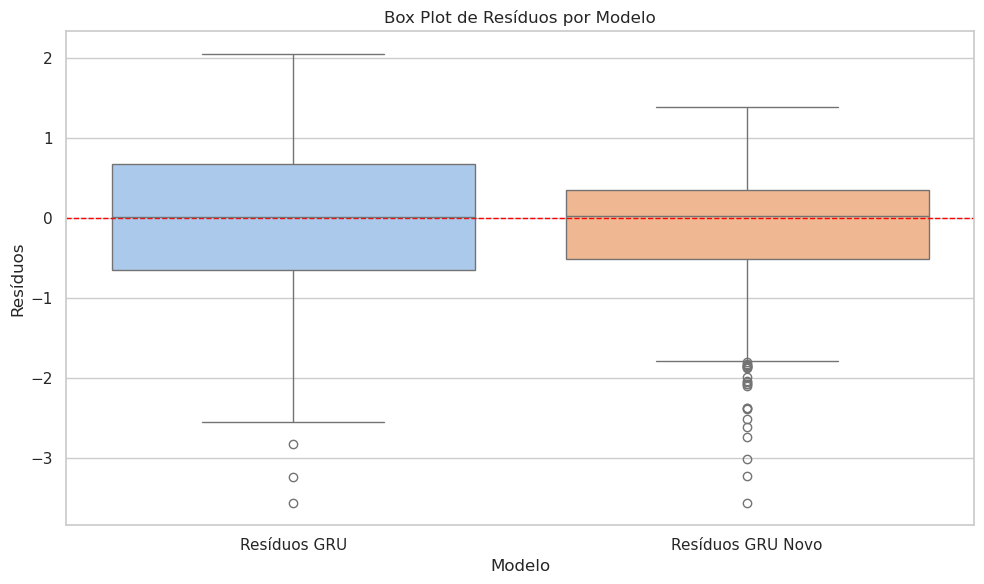

,Resíduos GRU,Resíduos GRU Novo
count,399.000000,399.000000
mean,-0.048579,-0.163967
std,0.963963,0.819928
min,-3.557271,-3.553890
25%,-0.652271,-0.511719
50%,0.009958,0.019618
75%,0.671037,0.345334
max,2.048801,1.386787


In [68]:
from scipy.stats import skew, kurtosis

def plot_combined_boxplot(forecast1, forecast2, target1, target2):
    # Calculando os resíduos para cada modelo
    preds_residuals1 = forecast1 - target1
    preds_residuals2 = forecast2 - target2

    # Criando DataFrame com os resíduos
    df_residuos = pd.DataFrame({
        'Resíduos GRU': preds_residuals1,
        'Resíduos GRU Novo': preds_residuals2,
    })


    # Convertendo o DataFrame para o formato "longo" necessário para o Seaborn
    df_residuos_melted = df_residuos.melt(var_name='Modelo', value_name='Resíduos')

    # Criando o boxplot combinado
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_residuos_melted, x='Modelo', y='Resíduos', palette='pastel')

    # Adicionando linha horizontal para zero
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

    # Configurações do gráfico
    plt.title('Box Plot de Resíduos por Modelo')
    plt.ylabel('Resíduos')
    plt.xlabel('Modelo')

    # Ajustando o layout e salvando a figura
    plt.tight_layout()
    plt.savefig('combined_boxplot_novo.png')
    plt.show()
    display(df_residuos.describe())
    return df_residuos


df_residuos = plot_combined_boxplot(old_preds, new_preds, target_gru, target)

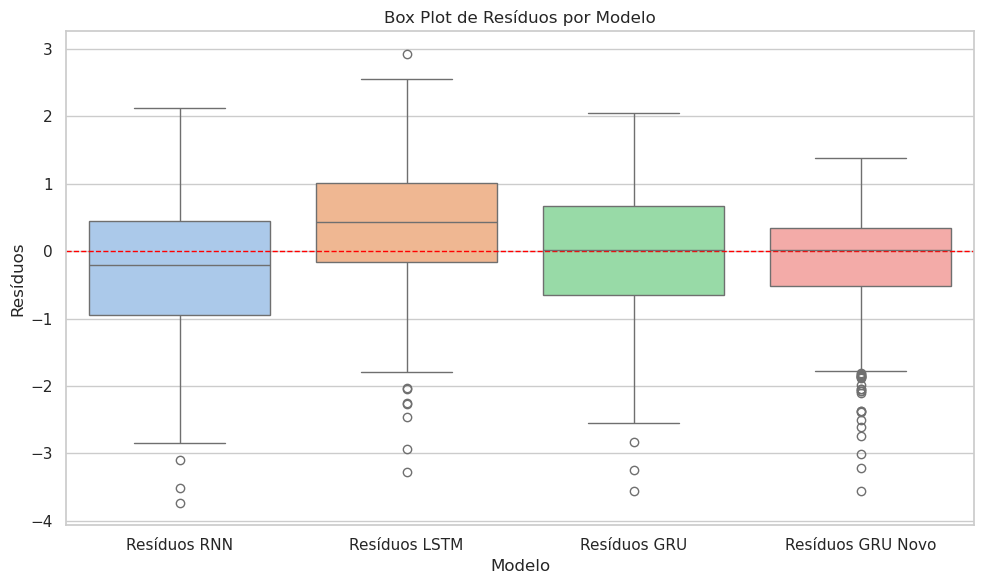

,Resíduos RNN,Resíduos LSTM,Resíduos GRU,Resíduos GRU Novo
count,399.000000,399.000000,399.000000,399.000000
mean,-0.295692,0.373808,-0.048579,-0.163967
std,0.992312,0.967087,0.963963,0.819928
min,-3.731228,-3.279119,-3.557271,-3.553890
25%,-0.941556,-0.159073,-0.652271,-0.511719
50%,-0.209873,0.427741,0.009958,0.019618
75%,0.451842,1.011353,0.671037,0.345334
max,2.122162,2.926068,2.048801,1.386787


In [70]:
from scipy.stats import skew, kurtosis

def plot_combined_boxplot(forecast1, forecast2, forecast3, forecast4, target1, target2, target3, target4):
    # Calculando os resíduos para cada modelo
    preds_residuals1 = forecast1 - target1
    preds_residuals2 = forecast2 - target2
    preds_residuals3 = forecast3 - target3
    preds_residuals4 = forecast4 - target4

    # Criando DataFrame com os resíduos
    df_residuos = pd.DataFrame({
        'Resíduos RNN': preds_residuals1,
        'Resíduos LSTM': preds_residuals2,
        'Resíduos GRU': preds_residuals3,
        'Resíduos GRU Novo': preds_residuals4
    })


    # Convertendo o DataFrame para o formato "longo" necessário para o Seaborn
    df_residuos_melted = df_residuos.melt(var_name='Modelo', value_name='Resíduos')

    # Criando o boxplot combinado
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_residuos_melted, x='Modelo', y='Resíduos', palette='pastel')

    # Adicionando linha horizontal para zero
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

    # Configurações do gráfico
    plt.title('Box Plot de Resíduos por Modelo')
    plt.ylabel('Resíduos')
    plt.xlabel('Modelo')

    # Ajustando o layout e salvando a figura
    plt.tight_layout()
    plt.savefig('combined_boxplot_novo.png')
    plt.show()
    display(df_residuos.describe())
    return df_residuos


df_residuos = plot_combined_boxplot(preds_rnn, preds_lstm, preds_gru, new_preds, target_rnn, target_lstm, target_gru, target)

In [72]:
from scipy.stats import median_abs_deviation

rmse_rnn = np.sqrt(mean_squared_error(target_rnn, preds_rnn))
mae_rnn = mean_absolute_error(target_rnn, preds_rnn)
corr_rnn = np.corrcoef(target_rnn, preds_rnn)[0, 1]
r2_rnn = r2_score(target_rnn, preds_rnn)
mad_rnn = median_abs_deviation(df_residuos['Resíduos RNN'])

# Calculate RMSE and MAE for LSTM
rmse_lstm = np.sqrt(mean_squared_error(target_lstm, preds_lstm))
mae_lstm = mean_absolute_error(target_lstm, preds_lstm)
corr_lstm = np.corrcoef(target_lstm, preds_lstm)[0, 1]
r2_lstm = r2_score(target_lstm, preds_lstm)
mad_lstm = median_abs_deviation(df_residuos['Resíduos LSTM'])

# Calculate RMSE and MAE for GRU
rmse_gru = np.sqrt(mean_squared_error(target_gru, preds_gru))
mae_gru = mean_absolute_error(target_gru, preds_gru)
corr_gru = np.corrcoef(target_gru, preds_gru)[0, 1]
r2_gru = r2_score(target_gru, preds_gru)
mad_gru = median_abs_deviation(df_residuos['Resíduos GRU'])

#Calculate Rmse, mae, corr e r² for rnn new

rmse_new_gru = np.sqrt(mean_squared_error(target.flatten(), preds.flatten()))
mae_new_gru = mean_absolute_error(target.flatten(), preds.flatten())
corr_new = np.corrcoef(target.flatten(), preds.flatten())[0, 1]
r2_new = r2_score(target.flatten(), preds.flatten())
mad_new = median_abs_deviation(df_residuos['Resíduos GRU Novo'])


# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Model': ['RNN', 'LSTM', 'GRU', 'GRU Novo'],
    'RMSE': [rmse_rnn, rmse_lstm, rmse_gru, rmse_new_gru],
    'MAE': [mae_rnn, mae_lstm, mae_gru, mae_new_gru],
    'Correlation': [corr_rnn, corr_lstm, corr_gru, corr_new],
    'R2': [r2_rnn, r2_lstm, r2_gru, r2_new],
    'MAD': [mad_rnn, mad_lstm, mad_gru, mad_new]
})

results_df.sort_values(by='RMSE')

,Model,RMSE,MAE,Correlation,R2,MAD
3,GRU Novo,0.835154,0.598881,0.783213,0.590805,0.386066
2,GRU,0.963979,0.771836,0.715302,0.454830,0.663014
0,RNN,1.034238,0.821878,0.715352,0.372466,0.694206
1,LSTM,1.035686,0.836669,0.704452,0.370707,0.585035


## Testes com dados de Pixels Próximos

In [110]:
#torch.save(learn.state_dict(), 'modelo/gru_novo.pth')

In [120]:
#with open('./modelo/gru_novo.pkl', 'wb') as f:
#    pickle.dump(learn, f)

In [121]:
with open('./modelo/gru_novo.pkl', 'rb') as f:
    novo_model = pickle.load(f) # carregando o melhor modelo

In [122]:
def modis_date(data_str):
    ano = int(data_str[1:5])
    dia_ano = int(data_str[5:])
    data = datetime.strptime('{}-{}'.format(ano, dia_ano), '%Y-%j')
    return data


dados = pd.read_csv('./Dados_Utilizados/nee_mean.csv', header=None)
dados.index = dados[2].apply(modis_date)  # Convertendo a data no formato MODIS

# Arrumando o dataframe
# ================================
dados = dados.drop([0,1,2,3,4], axis=1)
dados.columns = range(len(dados.columns))
dados

,0,1,2,3,4,5,6,7,8
2,,,,,,,,,
2015-03-31,0.640952,0.425038,-0.140538,0.678668,0.648975,0.190089,0.604259,0.766604,0.085412
2015-04-01,0.909254,0.812770,0.466847,0.922994,1.023345,0.770050,0.846479,1.122539,0.689502
2015-04-02,0.297901,0.391385,0.109438,0.258081,0.544442,0.390803,0.083746,0.574607,0.186040
2015-04-03,-1.463920,-1.665904,-2.506463,-1.413853,-1.395835,-1.824845,-1.647345,-1.302068,-2.073230
2015-04-04,-1.256701,-1.470213,-2.330762,-1.196943,-1.187410,-1.652637,-1.410650,-1.080677,-1.866451
...,...,...,...,...,...,...,...,...,...
2024-05-27,1.182478,0.821253,0.296096,1.221200,1.043784,0.596609,1.123635,0.874791,0.129703
2024-05-28,0.340297,-0.155570,-0.684469,0.299741,0.006970,-0.355151,0.026459,-0.267378,-0.864434
2024-05-29,-0.035294,-0.523938,-0.981260,-0.055757,-0.344878,-0.655920,-0.367406,-0.643677,-1.220401


In [123]:
def combine_residuals(preds, targets, model_names, dataset_id):
    residuals = {name: preds[name] - targets[name] for name in model_names}
    df_residuos = pd.DataFrame(residuals)
    df_residuos['Dataset'] = dataset_id
    return df_residuos

# Função para plotar resíduos combinados
def plot_combined_residuals(df_residuos_combined):
    df_residuos_melted = df_residuos_combined.melt(id_vars='Dataset', var_name='Modelo', value_name='Resíduos')
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df_residuos_melted, x='Dataset', y='Resíduos', hue='Modelo', palette='pastel')
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
    plt.title('Resíduos por Conjunto de Dados e Modelo')
    plt.ylabel('Resíduos')
    plt.xlabel('Conjunto de Dados')
    plt.legend(title='Modelo', loc='upper right')
    plt.tight_layout()
    plt.savefig('combined_residuals_boxplot.png')
    plt.show()


def evaluate_models(preds_dict, targets_dict, model_names):
    results = []
    for model_name in model_names:
        preds = preds_dict.get(model_name)
        targets = targets_dict.get(model_name)
        if preds is not None and targets is not None:
            rmse = np.sqrt(mean_squared_error(targets, preds))
            mae = mean_absolute_error(targets, preds)
            corr = np.corrcoef(targets, preds)[0, 1]
            r2 = r2_score(targets, preds)
            results.append({
                'Model': model_name,
                'RMSE': rmse,
                'MAE': mae,
                'Correlation': corr,
                'R2': r2
            })
    results_df = pd.DataFrame(results)
    return results_df.sort_values(by='RMSE')

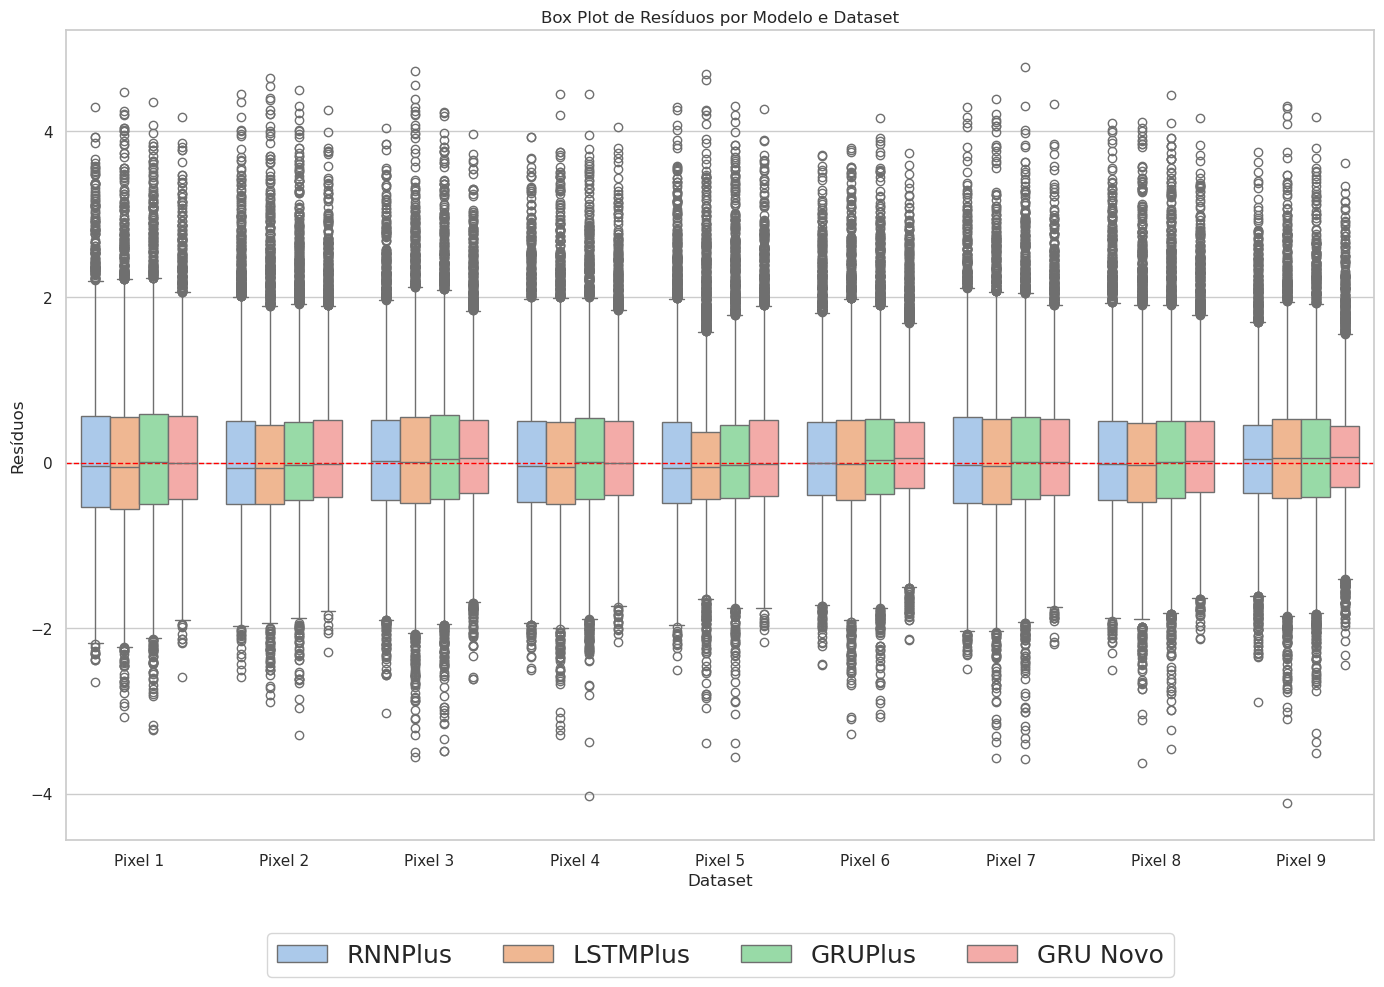

In [125]:
def plot_combined_boxplot(preds, targets, model_names, dataset_index):
    residuals = {name: preds[name] - targets[name] for name in model_names}
    df_residuos = pd.DataFrame(residuals)
    df_residuos['Dataset'] = f'Pixel {dataset_index + 1}'
    df_residuos_melted = df_residuos.melt(id_vars='Dataset', var_name='Modelo', value_name='Resíduos')

    return df_residuos_melted


modelos = {
    'RNNPlus': modelos['RNNPlus'],
    'LSTMPlus': modelos['LSTMPlus'],
    'GRUPlus': modelos['GRUPlus'],
    'GRU Novo': novo_model
}


dados = [dados[0], dados[1], dados[2], dados[3],dados[4],dados[5],dados[6],dados[7],dados[8]]


preds = {}
targets = {}


for i, dado in enumerate(dados):
    X, y = SlidingWindow(7, horizon=7, stride=4)(dado.values)
    
    for nome_modelo, modelo in modelos.items():
        target, preds_, _ = modelo.get_X_preds(X, y)
        
        preds_numpy = preds_.detach().numpy().flatten() if isinstance(preds_, torch.Tensor) else preds_.numpy().flatten()
        target_numpy = target.detach().numpy().flatten() if isinstance(target, torch.Tensor) else target.numpy().flatten()

        preds[f'{nome_modelo}_{i}'] = preds_numpy
        targets[f'{nome_modelo}_{i}'] = target_numpy


df_residuos_melted_list = []
for i in range(len(dados)):
    preds_model = {name: preds[f'{name}_{i}'] for name in modelos.keys()}
    targets_model = {name: targets[f'{name}_{i}'] for name in modelos.keys()}
    
    df_residuos_melted = plot_combined_boxplot(preds_model, targets_model, list(modelos.keys()), i)
    df_residuos_melted_list.append(df_residuos_melted)

# Concatenar todos os DataFrames para fazer um único plot
df_residuos_combined = pd.concat(df_residuos_melted_list, ignore_index=True)

# Criando o boxplot combinado
plt.figure(figsize=(14, 10))
sns.boxplot(data=df_residuos_combined, x='Dataset', y='Resíduos', hue='Modelo', palette='pastel')

# Adicionando linha horizontal para zero
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Configurações do gráfico
plt.title('Box Plot de Resíduos por Modelo e Dataset')
plt.ylabel('Resíduos')
plt.xlabel('Dataset')

# Ajustando o layout e mostrando o gráfico
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=18)
plt.tight_layout()
plt.show()

In [126]:
model_names = ['RNNPlus', 'LSTMPlus', 'GRUPlus', 'GRU Novo']

# Armazenar todos os resultados em um DataFrame para cada conjunto de dados
all_results = []

for i in range(len(dados)):
    preds_model = {name: preds[f'{name}_{i}'] for name in model_names}
    targets_model = {name: targets[f'{name}_{i}'] for name in model_names}
    
    df_metricas = evaluate_models(preds_model, targets_model, model_names)
    
    # Adicionar um identificador para o conjunto de dados
    df_metricas['Dataset'] = i
    all_results.append(df_metricas)
    
    # Exibindo as estatísticas descritivas dos resíduos
    print(f'Estatísticas descritivas para o conjunto de dados {i}:')
    print(df_residuos)
    print('\n')

# Consolidar resultados em um único DataFrame
all_results_df = pd.concat(all_results)
display(all_results_df)

Estatísticas descritivas para o conjunto de dados 0:
     Resíduos RNN  Resíduos LSTM  Resíduos GRU  Resíduos GRU Novo
0        1.767337       2.926068      2.014368           0.218132
1        1.720807       1.954773      1.597909           0.077892
2        1.372293       2.421759      1.615312           0.518536
3        1.073278       2.080783      1.398148           0.677873
4        0.352572       1.279725      0.680329           0.200881
..            ...            ...           ...                ...
394      0.353757       0.846683      0.608238          -0.133593
395      0.576820       1.139819      0.860126           0.014376
396     -1.046552      -0.513037     -0.877359          -1.484739
397     -0.252251       0.341157      0.032421          -0.485538
398      0.109090       0.708126      0.392613           0.078680

[399 rows x 4 columns]


Estatísticas descritivas para o conjunto de dados 1:
     Resíduos RNN  Resíduos LSTM  Resíduos GRU  Resíduos GRU Novo
0        1

,Model,RMSE,MAE,Correlation,R2,Dataset
3,GRU Novo,0.846216,0.634990,0.736330,0.196619,0
0,RNNPlus,0.924865,0.705103,0.672411,0.007221,0
2,GRUPlus,0.948724,0.710968,0.664766,0.117260,0
1,LSTMPlus,0.956784,0.720789,0.651973,0.050479,0
3,GRU Novo,0.826131,0.608830,0.736016,0.162753,1
0,RNNPlus,0.885088,0.661070,0.685273,0.021379,1
1,LSTMPlus,0.887856,0.651029,0.687151,0.139605,1
2,GRUPlus,0.889141,0.649787,0.691376,0.173723,1
3,GRU Novo,0.805602,0.592699,0.584876,-0.342945,2
0,RNNPlus,0.866839,0.644007,0.506224,-0.502537,2


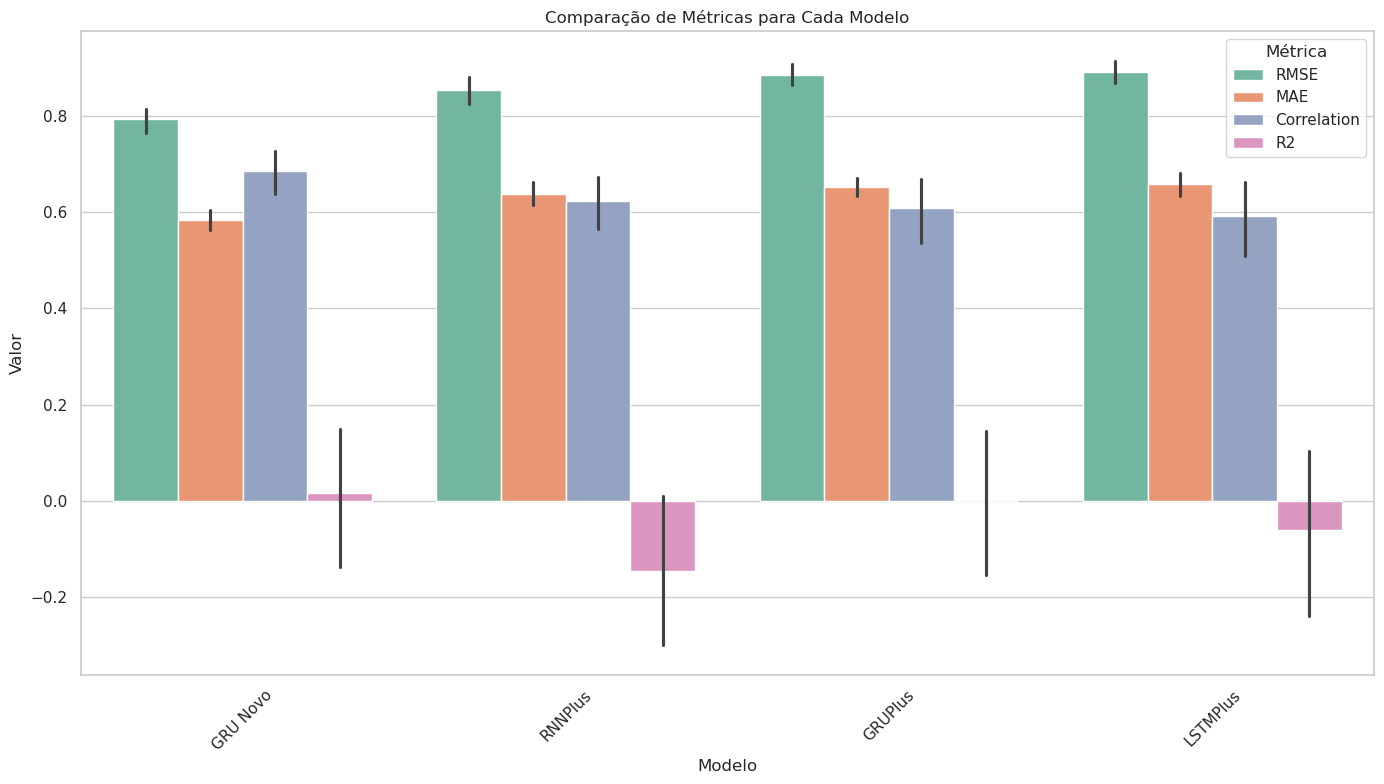

In [128]:
results_df_melted = all_results_df.drop(columns='Dataset').melt(id_vars='Model', var_name='Métrica', value_name='Valor')

# Criar gráfico de barras agrupadas
plt.figure(figsize=(14, 8))
sns.barplot(data=results_df_melted, x='Model', y='Valor', hue='Métrica', palette='Set2')

# Configurações do gráfico
plt.title('Comparação de Métricas para Cada Modelo')
plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.legend(title='Métrica')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Imagens/Comparação_de_Métricas_Pixels_Próximos.png")
plt.show()

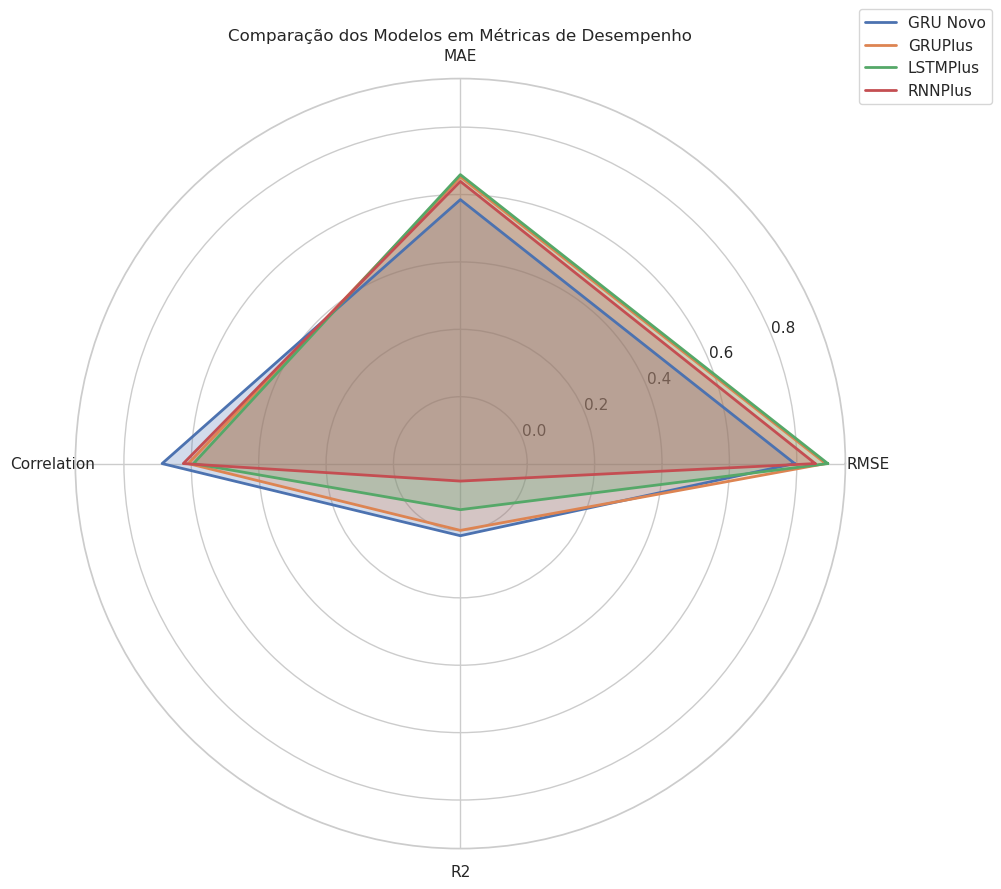

In [94]:
# Calcular a média das métricas por modelo
mean_metrics = all_results_df.drop('Dataset',axis=1).groupby('Model').mean().reset_index()

# Preparar dados para o gráfico de radar
labels = mean_metrics.columns[1:]  # Ignorando a coluna 'Model'
num_vars = len(labels)

# Criar um array para armazenar as médias
values = mean_metrics[labels].values.flatten().tolist()
values += values[:1]  # Fechar o gráfico

# Criar ângulos para o gráfico de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Fechar o gráfico

# Criar o gráfico de radar
plt.figure(figsize=(10, 10))

# Plotar cada modelo
for i in range(len(mean_metrics)):
    model = mean_metrics['Model'][i]
    model_values = mean_metrics.loc[i, labels].values.flatten().tolist()
    model_values += model_values[:1]  # Fechar o gráfico
    
    plt.subplot(1, 1, 1, polar=True)
    plt.fill(angles, model_values, alpha=0.25)
    plt.plot(angles, model_values, linewidth=2, label=model)

# Ajustar o gráfico
plt.xticks(angles[:-1], labels)
plt.title('Comparação dos Modelos em Métricas de Desempenho')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()